In [612]:
import pandas as pd
import json
import re
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sup_functions import barplot_group, barplot_balance

In [613]:
df_dota = pd.read_csv('dota_dataset.csv')

In [614]:
df_dota.head(1)

,match_id,match_seq_num,radiant_win,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire,cluster,...,radiant_xp_adv,teamfights,version,cosmetics,radiant_score,dire_score,draft_timings,series_id,series_type,replay_salt
0,7967435715,6702702284,True,1727730164,2134,1844,1536,63,0,346,...,"[0, 106, -257, 63, 234, 233, -224, 650, 89, 20...","[{'start': 456, 'end': 542, 'last_death': 527,...",21.0,"{'647': 129, '5156': 129, '6441': 129, '6507':...",39,6,"[{'order': 1, 'pick': False, 'active_team': 3,...",910729,1,2020287346


In [615]:
to_drop = ['match_seq_num', 'start_time', 'cluster', 'human_players', 'positive_votes', 'negative_votes', 
           'engine', 'radiant_team_id', 'dire_team_id', 'radiant_team_name', 'dire_team_name', 
           'radiant_team_complete', 'dire_team_complete', 'radiant_captain', 'dire_captain', 
           'chat', 'cosmetics', 'draft_timings', 'replay_salt', 'lobby_type', 'version', 'series_id', 'series_type',
           'leagueid', 'first_blood_time', 'objectives', 'teamfights', 'game_mode']

In [616]:
df_dota.drop(columns=to_drop, inplace=True)

In [617]:
df_dota.columns

Index(['match_id', 'radiant_win', 'duration', 'tower_status_radiant',
       'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire',
       'picks_bans', 'radiant_gold_adv', 'radiant_xp_adv', 'radiant_score',
       'dire_score'],
      dtype='object')

In [618]:
df_dota.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11334 entries, 0 to 11333
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   match_id                 11334 non-null  int64 
 1   radiant_win              11334 non-null  bool  
 2   duration                 11334 non-null  int64 
 3   tower_status_radiant     11334 non-null  int64 
 4   tower_status_dire        11334 non-null  int64 
 5   barracks_status_radiant  11334 non-null  int64 
 6   barracks_status_dire     11334 non-null  int64 
 7   picks_bans               11332 non-null  object
 8   radiant_gold_adv         11314 non-null  object
 9   radiant_xp_adv           11314 non-null  object
 10  radiant_score            11334 non-null  int64 
 11  dire_score               11334 non-null  int64 
dtypes: bool(1), int64(8), object(3)
memory usage: 985.2+ KB


In [619]:
df_dota = df_dota.dropna(subset=['radiant_gold_adv', 'radiant_xp_adv'])

In [620]:
df_dota = df_dota.dropna(subset=['picks_bans'])

Гипотеза 1:
Определённые тэги персонажей влияют на победу или поражение

В комьюнити дота 2 бытует мнение о том, что если не знаешь, что брать, бери станы. Станы - это способности, которые выводят из строя героев врага. 

С помощью признака picks_bans мы можем узнать набор героев команды radiant, победа или поражение которой является целевой переменной. Гипотезу мы будем проверять введением новых признаков 'Pusher', 'Escape', 'Carry', 'Initiator', 'Durable',  'Nuker', 'Support', 'Disabler'. Каждый персонаж, в зависимости от его способностей, обладает несколькими характеристиками из этого списка, которые его в кратце описывают. Например, если у героя есть способность, которая обездвиживает врага, у него будет тэг 'Disabler'.

План такой: 
1) Признак picks_bans, который показывает наборы героев на игру соединить со списком всех героев и их описанием (df_heroes).
2) Создать признаки уникальных тэгов (перечислены выше) и в бинаризованном виде подставить к каждому выбору героя по очереди в кажном матче.
3) Сгруппировать по матчу и суммиравать метки тэгов.

Таким образом, для кажного матча мы получим количество тех или иных характеристик выбранных героев.

In [621]:
df_dota = df_dota.dropna(subset=['picks_bans'])

In [622]:
print(df_dota['picks_bans'].iloc[0])

[{'is_pick': False, 'hero_id': 19, 'team': 1, 'order': 0}, {'is_pick': False, 'hero_id': 16, 'team': 0, 'order': 1}, {'is_pick': False, 'hero_id': 80, 'team': 0, 'order': 2}, {'is_pick': False, 'hero_id': 48, 'team': 1, 'order': 3}, {'is_pick': False, 'hero_id': 79, 'team': 0, 'order': 4}, {'is_pick': False, 'hero_id': 11, 'team': 0, 'order': 5}, {'is_pick': False, 'hero_id': 119, 'team': 1, 'order': 6}, {'is_pick': True, 'hero_id': 100, 'team': 1, 'order': 7}, {'is_pick': True, 'hero_id': 128, 'team': 0, 'order': 8}, {'is_pick': False, 'hero_id': 108, 'team': 1, 'order': 9}, {'is_pick': False, 'hero_id': 96, 'team': 1, 'order': 10}, {'is_pick': False, 'hero_id': 114, 'team': 0, 'order': 11}, {'is_pick': True, 'hero_id': 69, 'team': 0, 'order': 12}, {'is_pick': True, 'hero_id': 94, 'team': 1, 'order': 13}, {'is_pick': True, 'hero_id': 86, 'team': 1, 'order': 14}, {'is_pick': True, 'hero_id': 58, 'team': 0, 'order': 15}, {'is_pick': True, 'hero_id': 21, 'team': 0, 'order': 16}, {'is_pic

In [623]:
pb = pd.DataFrame()

In [624]:
df_pb_list = []

for s in df_dota['picks_bans'].astype(str):
    df_pb = pd.json_normalize(eval(s))  # Use the correct variable name
    df_pb_list.append(df_pb)

# Concatenate all DataFrames in the list outside the loop
result_df = pd.concat(df_pb_list)

In [625]:
result_df = result_df[result_df['is_pick'] == True]

In [626]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113120 entries, 7 to 23
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   is_pick  113120 non-null  bool 
 1   hero_id  113120 non-null  int64
 2   team     113120 non-null  int64
 3   order    113120 non-null  int64
dtypes: bool(1), int64(3)
memory usage: 3.6 MB


In [627]:
df_dota.shape

(11312, 12)

In [628]:
pick_bans_id = df_dota['match_id'].tolist()

In [629]:
pick_bans_id = [item for item in pick_bans_id for _ in range(10)]

In [630]:
len(pick_bans_id)

113120

In [631]:
len(result_df)

113120

In [632]:
result_df.loc[:, 'match_id'] = pick_bans_id

In [633]:
result_df.head(15)

,is_pick,hero_id,team,order,match_id
7,True,100,1,7,7967435715
8,True,128,0,8,7967435715
12,True,69,0,12,7967435715
13,True,94,1,13,7967435715
14,True,86,1,14,7967435715
15,True,58,0,15,7967435715
16,True,21,0,16,7967435715
17,True,74,1,17,7967435715
22,True,137,1,22,7967435715
23,True,106,0,23,7967435715


In [634]:
result_df.drop(columns=['is_pick', 'order'], inplace=True)

Оставим только выбор героев команды radiant (team = 0), так как целевая переменная показывает результат матча относительно команды radiant.

In [635]:
result_df = result_df[result_df['team'] == 0]

In [636]:
result_df.drop(columns=['team'], inplace=True)

In [637]:
result_df.head(10)

,hero_id,match_id
8,128,7967435715
12,69,7967435715
15,58,7967435715
16,21,7967435715
23,106,7967435715
8,49,7967438032
12,79,7967438032
15,9,7967438032
16,38,7967438032
23,19,7967438032


In [638]:
df_heroes = pd.read_csv('heroes.csv')

In [639]:
df_heroes.head()

,id,name,localized_name,primary_attr,attack_type,roles,legs
0,47,npc_dota_hero_viper,Viper,agi,Ranged,"['Carry', 'Durable', 'Initiator', 'Disabler']",0
1,48,npc_dota_hero_luna,Luna,agi,Ranged,"['Carry', 'Nuker', 'Pusher']",2
2,50,npc_dota_hero_dazzle,Dazzle,all,Ranged,"['Support', 'Nuker', 'Disabler']",2
3,51,npc_dota_hero_rattletrap,Clockwerk,all,Melee,"['Initiator', 'Disabler', 'Durable', 'Nuker']",2
4,52,npc_dota_hero_leshrac,Leshrac,int,Ranged,"['Carry', 'Support', 'Nuker', 'Pusher', 'Disab...",4


In [640]:
heroes_drop = ['name', 'primary_attr', 'attack_type', 'legs', 'localized_name']

In [641]:
df_heroes.drop(columns=heroes_drop, axis=1, inplace=True)

In [642]:
df_heroes.set_index('id', inplace=True)

In [643]:
df_heroes.sort_index(inplace=True)

In [644]:
result_df.set_index('hero_id',inplace=True)

In [645]:
df_picks_roles = result_df.join(df_heroes, how='inner', on='hero_id')

In [646]:
df_picks_roles.reset_index(inplace=True)

In [647]:
df_picks_roles.head(10)

,hero_id,match_id,roles
0,128,7967435715,"['Support', 'Nuker', 'Disabler', 'Escape']"
1,69,7967435715,"['Carry', 'Disabler', 'Initiator', 'Durable', ..."
2,58,7967435715,"['Support', 'Pusher', 'Durable', 'Disabler']"
3,21,7967435715,"['Carry', 'Support', 'Disabler', 'Escape', 'Nu..."
4,106,7967435715,"['Carry', 'Escape', 'Nuker', 'Disabler', 'Init..."
5,49,7967438032,"['Carry', 'Pusher', 'Durable', 'Disabler', 'In..."
6,79,7967438032,"['Support', 'Disabler', 'Initiator', 'Nuker']"
7,9,7967438032,"['Carry', 'Support', 'Escape', 'Nuker', 'Disab..."
8,38,7967438032,"['Initiator', 'Disabler', 'Durable', 'Nuker']"
9,19,7967438032,"['Carry', 'Nuker', 'Pusher', 'Initiator', 'Dur..."


In [648]:
df_picks_roles['roles'] = df_picks_roles['roles'].str.strip('[]') 

In [649]:
df_picks_roles['roles'] = df_picks_roles['roles'].apply(lambda x: x.replace(', ', ' ').replace("'", ''))

In [650]:
roles_list = df_picks_roles['roles'].str.split().explode().tolist()

# Получим список уникальных ролей
unique_roles = list(set(roles_list))

In [651]:
unique_roles

['Support',
 'Initiator',
 'Pusher',
 'Escape',
 'Nuker',
 'Carry',
 'Durable',
 'Disabler']

In [652]:
#Развернем признак roles по всем уникальным ролям, отмечая наличие/отсутствие на каждом выборе героя 
for role in unique_roles:
    df_picks_roles[role] = df_picks_roles['roles'].str.contains(role).astype(int)

In [653]:
df_picks_roles.head(2)

,hero_id,match_id,roles,Support,Initiator,Pusher,Escape,Nuker,Carry,Durable,Disabler
0,128,7967435715,Support Nuker Disabler Escape,1,0,0,1,1,0,0,1
1,69,7967435715,Carry Disabler Initiator Durable Nuker,0,1,0,0,1,1,1,1


In [654]:
df_picks_roles.drop(columns=['roles', 'hero_id'], axis=1, inplace=True)

In [655]:
summed_roles_by_match = df_picks_roles.groupby('match_id').sum().reset_index()

In [656]:
summed_roles_by_match

,match_id,Support,Initiator,Pusher,Escape,Nuker,Carry,Durable,Disabler
0,7923029379,4,3,0,5,4,1,1,5
1,7923037228,0,3,2,0,5,4,3,3
2,7923076640,3,1,0,3,5,1,1,4
3,7923111135,3,0,0,1,4,3,2,3
4,7923140944,2,2,1,2,4,2,1,3
...,...,...,...,...,...,...,...,...,...
11307,8135934305,3,4,1,1,3,3,3,5
11308,8135935642,3,2,1,3,4,3,2,4
11309,8135947801,2,3,2,0,5,3,2,4
11310,8135958166,1,2,0,2,3,3,2,3


In [657]:
summed_roles_by_match.set_index('match_id', inplace=True)

In [658]:
df_dota = df_dota.join(summed_roles_by_match, how='inner', on='match_id')

In [659]:
df_dota.drop(columns=['picks_bans'], inplace=True)

In [660]:
df_dota.head(3)

,match_id,radiant_win,duration,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire,radiant_gold_adv,radiant_xp_adv,radiant_score,dire_score,Support,Initiator,Pusher,Escape,Nuker,Carry,Durable,Disabler
0,7967435715,True,2134,1844,1536,63,0,"[0, 158, 99, 432, 976, 969, 660, 1224, 1065, 3...","[0, 106, -257, 63, 234, 233, -224, 650, 89, 20...",39,6,3,2,1,3,4,3,2,5
1,7967438032,True,2472,1974,260,63,63,"[0, 265, 265, 281, 316, 618, 1158, 846, 420, 8...","[0, 231, 278, 585, 626, 475, 951, -161, 1015, ...",22,15,2,4,2,1,5,3,3,5
2,7967459521,False,1712,1831,2038,63,63,"[0, -154, 387, 446, -586, -442, -647, 205, 64,...","[0, -154, 1, 82, -321, -24, -295, 186, 557, 68...",14,33,2,2,2,3,2,4,1,3


В доте 2 каждую партию условно можно разделить на 3 этапа: ранняя, средния и поздняя стадии игры. Есть устоявшееся мнение, что если выйграть стадию лайнинга (раннюю стадию), то вероятность победы уже 80%. Сформулируем новую гипотезу:

Гипотеза 2: Преимущество по золоту или опыту на ранней из стадии игры, значительно вляет на победу.

Обычно ранняя стадия длится 10 минут. На ней игроки стоят по трем линиям (2 1 2). Дальше идёт средняя стадия. На ней 3/4 игрока создают пространство для фарма игроков на роли кери и мидер. Поздняя стадия игры начинается примерно с 30 минуты, когда кери получил достаточно золота для хороших предметов, чтобы вносить пользу.

Исследовать зависимость преимущества на средней и поздней стадиях не имеет смысла, так как они будут иметь очень высокую корреляцию с целевой переменной

Признаки radiant_gold_adv и radiant_xp_adv емеют коммулятивный характер, то есть они показывают разницу в золоте и опыте между командами в определенный момент матча. Узнаем временной промежуток, по которому фиксируется значение в списке. Для этого посмотрим на время матча и длину списков нужных признаков первых трех матчей:

Переведем длину матча в минуты:

In [661]:
df_dota['duration'] = df_dota['duration'] // 60

In [662]:
df_dota.head(3)

,match_id,radiant_win,duration,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire,radiant_gold_adv,radiant_xp_adv,radiant_score,dire_score,Support,Initiator,Pusher,Escape,Nuker,Carry,Durable,Disabler
0,7967435715,True,35,1844,1536,63,0,"[0, 158, 99, 432, 976, 969, 660, 1224, 1065, 3...","[0, 106, -257, 63, 234, 233, -224, 650, 89, 20...",39,6,3,2,1,3,4,3,2,5
1,7967438032,True,41,1974,260,63,63,"[0, 265, 265, 281, 316, 618, 1158, 846, 420, 8...","[0, 231, 278, 585, 626, 475, 951, -161, 1015, ...",22,15,2,4,2,1,5,3,3,5
2,7967459521,False,28,1831,2038,63,63,"[0, -154, 387, 446, -586, -442, -647, 205, 64,...","[0, -154, 1, 82, -321, -24, -295, 186, 557, 68...",14,33,2,2,2,3,2,4,1,3


In [663]:
df_dota['radiant_gold_adv'].iloc[0]

'[0, 158, 99, 432, 976, 969, 660, 1224, 1065, 3356, 3844, 5286, 5556, 6342, 7954, 8874, 9709, 10929, 12096, 12996, 15432, 13964, 14368, 14850, 14146, 16063, 19486, 19782, 20174, 20785, 22487, 23977, 22238, 23060, 27017, 28156]'

Конвертируем все значения radiant_gold_adv и radiant_xp_adv в список

In [664]:
def convert_to_list(df, column):
    """Преобразует строку, представляющую список, в фактический список.

    Args:
    df: DataFrame.
    column: Название столбца для преобразования.

    Returns:
    DataFrame с преобразованным столбцом.
    """
    
    df[column] = df[column].apply(ast.literal_eval)
    return df

In [665]:
convert_to_list(df_dota, 'radiant_gold_adv').head(1)

,match_id,radiant_win,duration,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire,radiant_gold_adv,radiant_xp_adv,radiant_score,dire_score,Support,Initiator,Pusher,Escape,Nuker,Carry,Durable,Disabler
0,7967435715,True,35,1844,1536,63,0,"[0, 158, 99, 432, 976, 969, 660, 1224, 1065, 3...","[0, 106, -257, 63, 234, 233, -224, 650, 89, 20...",39,6,3,2,1,3,4,3,2,5


In [666]:
convert_to_list(df_dota, 'radiant_xp_adv').head(1)

,match_id,radiant_win,duration,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire,radiant_gold_adv,radiant_xp_adv,radiant_score,dire_score,Support,Initiator,Pusher,Escape,Nuker,Carry,Durable,Disabler
0,7967435715,True,35,1844,1536,63,0,"[0, 158, 99, 432, 976, 969, 660, 1224, 1065, 3...","[0, 106, -257, 63, 234, 233, -224, 650, 89, 20...",39,6,3,2,1,3,4,3,2,5


In [667]:
len(df_dota['radiant_gold_adv'].iloc[0])

36

In [668]:
df_dota['duration'].iloc[0]

35

Видим, что длина списка на единицу больше, но это не плохо, так как индексы списков соотносятся с соответствующей минутой матча

Взглянем на плотность распределения длины матчей, чтобы ограничить выборку от аномальных значений

<Axes: xlabel='duration', ylabel='Density'>

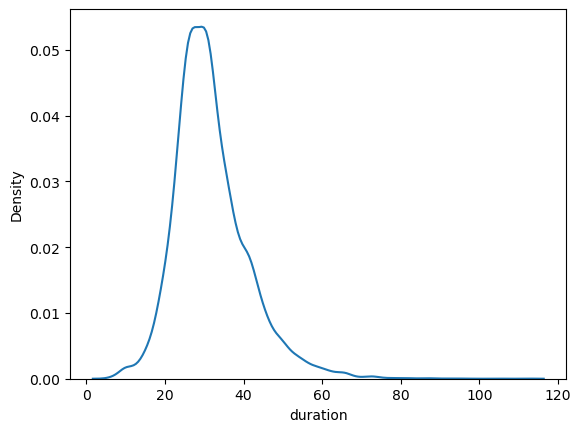

In [669]:
sns.kdeplot(df_dota['duration'])

In [670]:
df_dota['duration'].median()

30.0

Как видно из графика большинство матчей длятся в среднем 30 минут. Поскольку мы исследуем показатели на ранней стадии, то нам важно, чтобы игры, на которых обучалась модель, не заканчивались слишком рано (досрочно по желанию капитана проигрывающей команды) исходя из этого возьмем 25-ую минуту за начало средней стадии игры.

Как уже было сказано, ранняя стадия заканчивается примерно на 10 минуте. Чтобы выявить зависимость между преимуществом на этой стадии и победой нужно рассматривать матчи, которые длились достаточно долго (Если матч длился 11 минут, то очевидно, что преимущество будет у победителя). Поэтому возьмем за минимальное время матча - 20 минут. 

In [671]:
count_duration_more_then = (df_dota['duration'] <= 20).sum()
count_duration_more_then

796

In [672]:
df_dota.shape

(11312, 19)

Исключим всего 796 матчей из 11312. Можем себе позволить.

In [673]:
df_dota = df_dota[~(df_dota['duration'] <= 20)]

Получается, если ранняя стадия заканчивается на 10 минуте, то чтобы сформировать нужные признаки, нужно взять значения из списков radiant_gold_adv и radiant_xp_adv c индексом 10.

In [674]:
def calculate_stage_advantages(row):
    early_gold = row['radiant_gold_adv'][10]
    early_xp = row['radiant_xp_adv'][10]
    return pd.Series([early_gold, early_xp],
                     index=['early_game_gold_adv', 'early_game_xp_adv'])

In [675]:
df_dota[['early_game_gold_adv', 'early_game_xp_adv']] = df_dota.apply(calculate_stage_advantages, axis=1)

In [676]:
df_dota.drop(columns=['radiant_gold_adv', 'radiant_xp_adv'], inplace=True)

In [677]:
df_dota.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10516 entries, 0 to 11333
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   match_id                 10516 non-null  int64
 1   radiant_win              10516 non-null  bool 
 2   duration                 10516 non-null  int64
 3   tower_status_radiant     10516 non-null  int64
 4   tower_status_dire        10516 non-null  int64
 5   barracks_status_radiant  10516 non-null  int64
 6   barracks_status_dire     10516 non-null  int64
 7   radiant_score            10516 non-null  int64
 8   dire_score               10516 non-null  int64
 9   Support                  10516 non-null  int32
 10  Initiator                10516 non-null  int32
 11  Pusher                   10516 non-null  int32
 12  Escape                   10516 non-null  int32
 13  Nuker                    10516 non-null  int32
 14  Carry                    10516 non-null  int32
 15  Durable

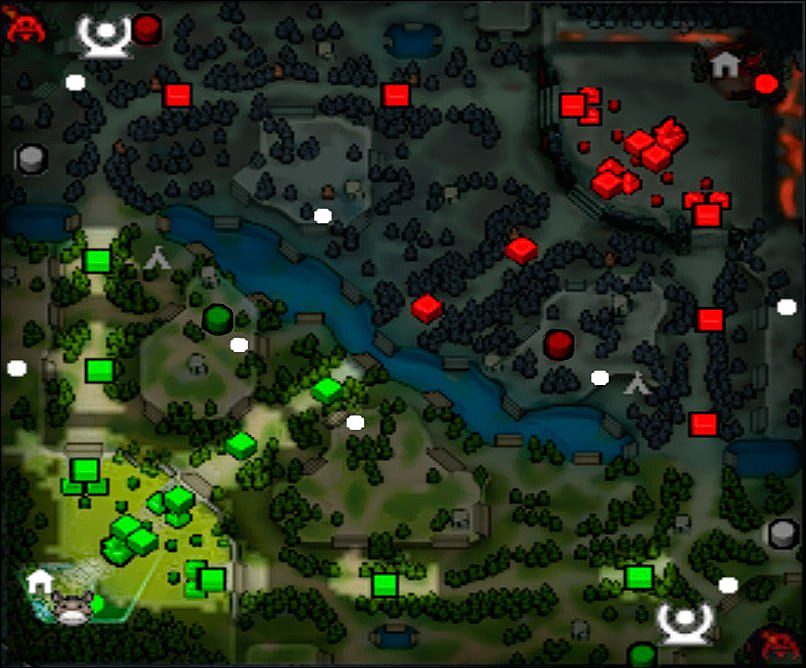

In [678]:
from IPython.display import Image
Image(filename=r'dota_map.jpeg', width=300, height=200) 

В доте 2, чтобы победить, нужно уничтожить главное строение врага "Древнего" (Defense of the Ancients) или в простонародье - "Трон". Чтобы добраться до него нужно уничтожить по одной из сторон все три башни, которые нумеруются от диагонали карты (1, 2, 3), два барака (строения рядом с третьей башей), а так же обе башни у самого трона. Сформулируем две связанные новые гипотезы.

В данном исследовании мы будем рассматривать только башни, которые находятся снаружи базы (по 6 с каждой из сторон), потому что вероятность победы будет слишком высока, если команде удалось уничтожить аж башни на базе врага.

Гипотеза 3: Некоторые союзные башни важнее остальных для победы.

Гипотеза 3.1: Уничтожение некоторых вражеских башен важнее остальных для победы.

Чтобы привести признаки tower_status_radiant, tower_status_dire к правильному виду (биноризовав), мы будем использовать вспомогательную памятку по соотношению цифр в бинаризованном значении и состоянию строений на конец игры.

Башни (войдите в режим редактирования ячейки для корректного отображения):

   ┌─┬─┬─┬─┬─────────────────────── Not used.
   │ │ │ │ │ ┌───────────────────── Ancient Bottom
   │ │ │ │ │ │ ┌─────────────────── Ancient Top
   │ │ │ │ │ │ │ ┌───────────────── Bottom Tier 3
   │ │ │ │ │ │ │ │ ┌─────────────── Bottom Tier 2
   │ │ │ │ │ │ │ │ │ ┌───────────── Bottom Tier 1
   │ │ │ │ │ │ │ │ │ │ ┌─────────── Middle Tier 3
   │ │ │ │ │ │ │ │ │ │ │ ┌───────── Middle Tier 2
   │ │ │ │ │ │ │ │ │ │ │ │ ┌─────── Middle Tier 1
   │ │ │ │ │ │ │ │ │ │ │ │ │ ┌───── Top Tier 3
   │ │ │ │ │ │ │ │ │ │ │ │ │ │ ┌─── Top Tier 2
   │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ ┌─ Top Tier 1
   │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [679]:
df_dota.head(2)

,match_id,radiant_win,duration,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire,radiant_score,dire_score,Support,Initiator,Pusher,Escape,Nuker,Carry,Durable,Disabler,early_game_gold_adv,early_game_xp_adv
0,7967435715,True,35,1844,1536,63,0,39,6,3,2,1,3,4,3,2,5,3844,1721
1,7967438032,True,41,1974,260,63,63,22,15,2,4,2,1,5,3,3,5,1238,484


Состояние башен и бараков закодированы. Чтобы привести их к нужной форме, используем бинаризацию:

In [680]:
towers_to_bin = lambda x: bin(x)[2:] + '0'*(11-len(bin(x)[2:]))

In [681]:
df_dota['tower_status_dire'] = df_dota['tower_status_dire'].apply(towers_to_bin)

In [682]:
df_dota['tower_status_radiant'] = df_dota['tower_status_radiant'].apply(towers_to_bin)

In [683]:
df_dota.head(2)

,match_id,radiant_win,duration,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire,radiant_score,dire_score,Support,Initiator,Pusher,Escape,Nuker,Carry,Durable,Disabler,early_game_gold_adv,early_game_xp_adv
0,7967435715,True,35,11100110100,11000000000,63,0,39,6,3,2,1,3,4,3,2,5,3844,1721
1,7967438032,True,41,11110110110,10000010000,63,63,22,15,2,4,2,1,5,3,3,5,1238,484


Исходя из своего игрового опыта и насмотренности профессиональных матчей по поводу бараков можно сказать, что если у вашей команды получилось уничтожить любые из барак, то вы и так уже очень близки к победе (корреляция с победой очень высокая, поэтому удалим признаки, связанные с состоянием бараков), потому что это очень важная цель на пути к трону. Помимо этого можно сказать, что снести Melee бараки намного важнее, так как у них со временем восстанавливается здоровье. Этим я хочу сказать, что неопределенность в потенциальной победе наибольшая в состоянии башен, потому что их уничтожение не позволяет героям телепортироваться в эту зону карты, тем самым уменьшая влияние на ней.

Цель проверки гипотезы состоит в определении наиболее важных башен, которые нужно защищать с большим усилием, и в определении башен противников, которые нужно снести в первую очередь, чтобы увеличить свой шанс на победу.

In [684]:
df_dota.drop(columns=['barracks_status_radiant', 'barracks_status_dire'], inplace = True)

Составим словарь с соотношением индекса в строке описания состояния башен и условных названий этих башен (см. ранее схему башен).

In [685]:
towers_name = {'ancient_bottom': 0, 'ancient_top': 1, 'bottom_tier_3': 2, 'bottom_tier_2': 3, 'bottom_tier_1': 4, 'middle_tier_3': 5, 'middle_tier_2': 6,
               'middle_tier_1': 7, 'top_tier_3': 8, 'top_tier_2': 9, 'top_tier_1': 10}

In [686]:
type(df_dota['tower_status_radiant'][0])

str

В соответствии с этой кодировкой, создадим признаки для кажного ключа словаря с соответствующим значением (0 или 1).

In [687]:
def create_tower_features(row: str, prefix: str) -> pd.Series:
    
    '''Функция для создания новых признаков
    row - строка датасета для дальнейшего
          применения lambda функции
    prefix - команда radint или dire
    '''
    new_features = {}
    for tower, index in towers_name.items():
        new_features[f"{prefix}_{tower}"] = int(row[index])
    return pd.Series(new_features)

In [688]:
df_dota['tower_status_radiant'].apply(lambda row: create_tower_features(row, 'radiant')).head(2)

,radiant_ancient_bottom,radiant_ancient_top,radiant_bottom_tier_3,radiant_bottom_tier_2,radiant_bottom_tier_1,radiant_middle_tier_3,radiant_middle_tier_2,radiant_middle_tier_1,radiant_top_tier_3,radiant_top_tier_2,radiant_top_tier_1
0,1,1,1,0,0,1,1,0,1,0,0
1,1,1,1,1,0,1,1,0,1,1,0


In [689]:
df_dota = df_dota.join(df_dota['tower_status_radiant'].apply(lambda row: create_tower_features(row, 'radiant')))
df_dota = df_dota.join(df_dota['tower_status_dire'].apply(lambda row: create_tower_features(row, 'dire')))

In [690]:
df_dota.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10516 entries, 0 to 11333
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   match_id                10516 non-null  int64 
 1   radiant_win             10516 non-null  bool  
 2   duration                10516 non-null  int64 
 3   tower_status_radiant    10516 non-null  object
 4   tower_status_dire       10516 non-null  object
 5   radiant_score           10516 non-null  int64 
 6   dire_score              10516 non-null  int64 
 7   Support                 10516 non-null  int32 
 8   Initiator               10516 non-null  int32 
 9   Pusher                  10516 non-null  int32 
 10  Escape                  10516 non-null  int32 
 11  Nuker                   10516 non-null  int32 
 12  Carry                   10516 non-null  int32 
 13  Durable                 10516 non-null  int32 
 14  Disabler                10516 non-null  int32 
 15  early_g

Удалим исходные признаки, а так же башни с тегами 2, 3 и "ancient" (потому что мы рассматриваем раннюю стадию игры для предсказания:

In [691]:
df_dota.drop(columns=['tower_status_radiant', 'tower_status_dire', 
                      'dire_bottom_tier_3','dire_middle_tier_3', 'dire_top_tier_3',
                      'dire_bottom_tier_2','dire_middle_tier_2', 'dire_top_tier_2','dire_ancient_top', 'dire_ancient_bottom', 
                      'radiant_bottom_tier_3','radiant_middle_tier_3', 'radiant_top_tier_3',
                      'radiant_bottom_tier_2','radiant_middle_tier_2', 'radiant_top_tier_2', 'radiant_ancient_top', 'radiant_ancient_bottom'], 
                      inplace= True)

Гипотеза 4: Разница в количестве убийств влияет на победу

Может показаться, что это довольно очевидно: чем больше убиваешь вражеских героев, тем богаче и опытнее становишься, но цель этой гипотезы выяснить, может важнее избегать драк и сосредоточиться на фарме? Такая ситуация имеет место в частных случаях в зависимости от выбора героев команд, но может так оказаться, что убийство нейтральных существ (в лесу) и вражеских существ (каждые 30 секунд выходят из бараков и идут по линиям) будет выгоднее.

Преобразуем признаки radiant_score и dire_score, которые показывают количество убийств вражеских героев за игру, в их разницу. Сами по тебе это не очень информативные данные, а вот их разница - да, так как, если ты убил вражеского героя, ты получаешь некоторое количество золота и опыта. 

Скорее всего эта разница будет высоко коррелирована с победой (если положительная) или с поражением (если отрицательная), но посмотреть на степень корреляции стоит.

In [692]:
df_dota['radiant_score_adv'] = df_dota['radiant_score'] - df_dota['dire_score']

In [693]:
df_dota.drop(columns=['radiant_score', 'dire_score'], inplace=True)

In [694]:
df_dota.columns

Index(['match_id', 'radiant_win', 'duration', 'Support', 'Initiator', 'Pusher',
       'Escape', 'Nuker', 'Carry', 'Durable', 'Disabler',
       'early_game_gold_adv', 'early_game_xp_adv', 'radiant_bottom_tier_1',
       'radiant_middle_tier_1', 'radiant_top_tier_1', 'dire_bottom_tier_1',
       'dire_middle_tier_1', 'dire_top_tier_1', 'radiant_score_adv'],
      dtype='object')

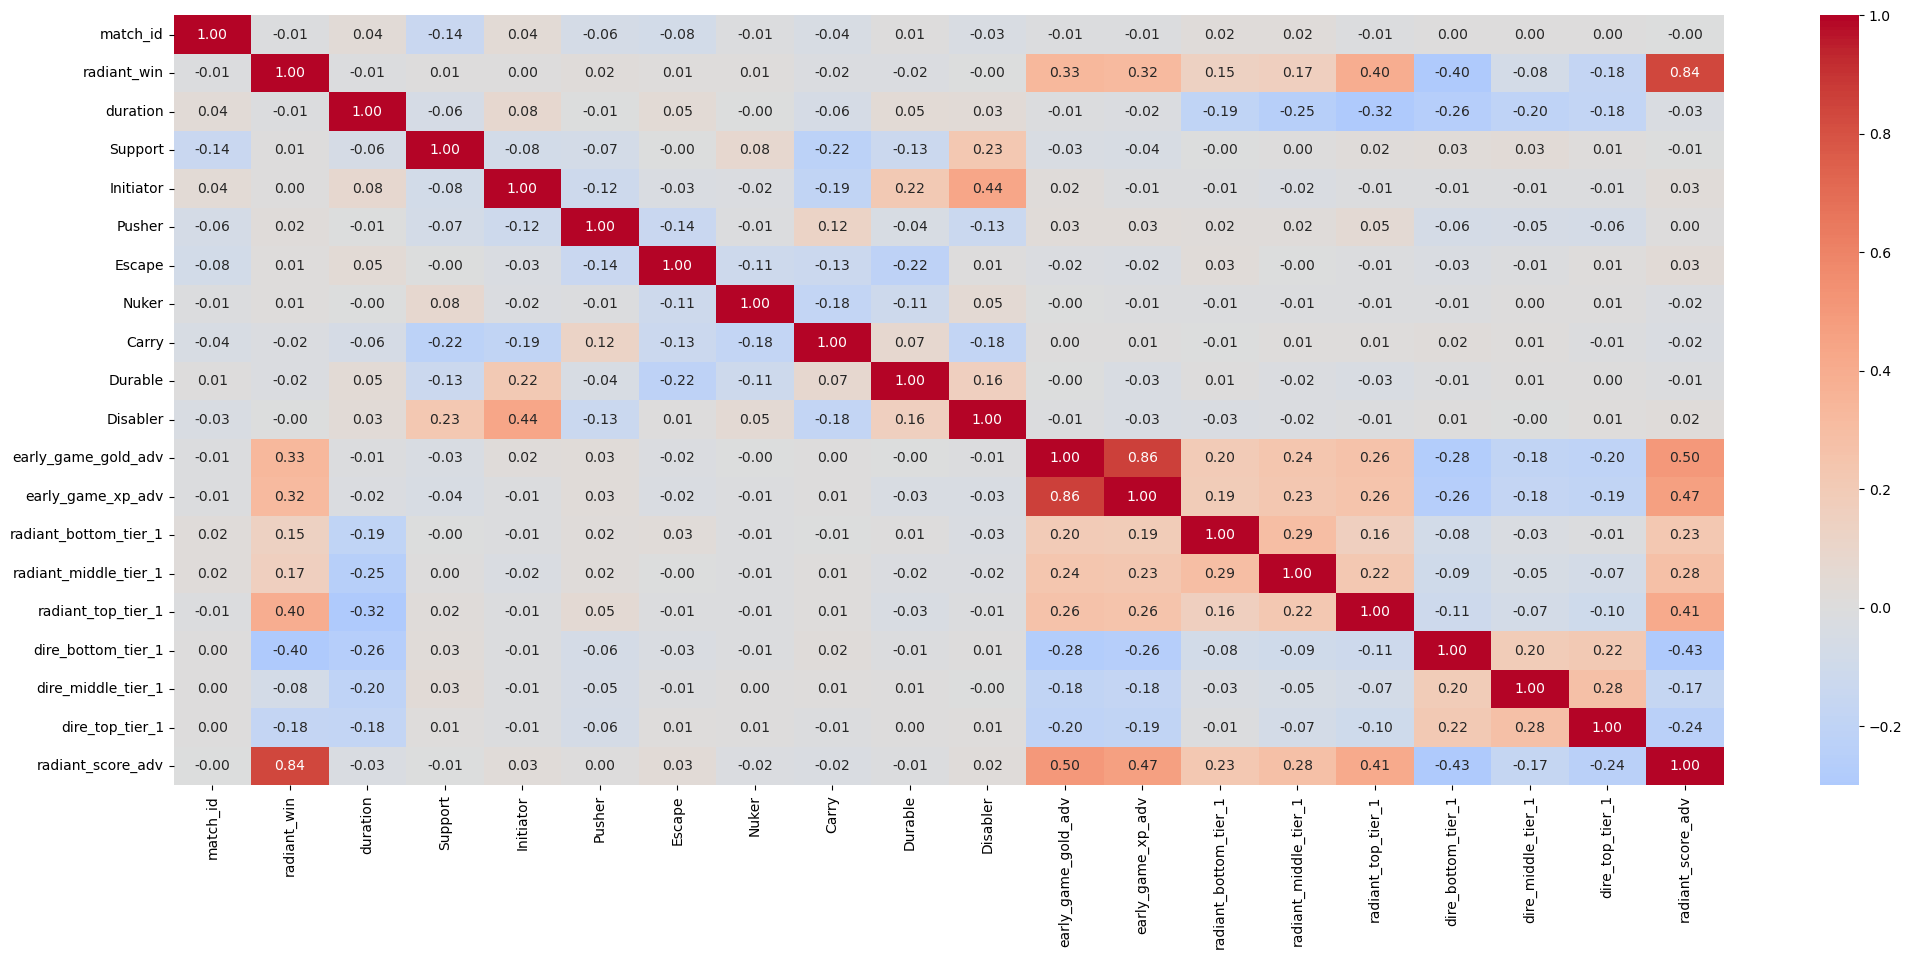

In [695]:
plt.figure(figsize=(25, 10))
sns.heatmap(df_dota.corr(method='spearman'), annot=True, 
            fmt='.2f', vmin=-0.3, center=0, cmap='coolwarm')
plt.show()

Глядя на целевую переменную radiant_win, можно отметить:
1) Есть как положительная так и отрицательная корреляция с тегами героев (хоть и не сильно выраженная)
2) Сохранение первой башни в топ линии важнее других первых башен. Это можно интерпретровать как: Если башню снесли, то кери противника имеет большее преимущество, так как он стоит именно там первые 10 минут. Тоже самое можно сказать и о первой башне противников, ее снос чаще приводит к победе.
Так же эта вышка позволяет быстро оказаться во вражеском лесу, где кери фармит (зарабатывает золото убивая нейтральных существ) лес. Его убийство позволяет снизить ему темп игры и отдалить от вещей, которые ему так нужны.
3) Нижняя вышка самая не важная для команды radiant, так как её уничтожение открывает не слишком большую часть карты, потому что недалеко есть доп строение на которое так же как и на башни можно телепортироваться (каждые 50 секунд).
4) Как отмечалось при написании гипотезы 4, признак 'radiant_score_adv' сильно коррелирует с победой и так как признаков не так много, то он сильно будет на нее влиять. Поэтому удалим его.

In [699]:
df_dota.drop(columns=['radiant_score_adv'], inplace=True)

C:\Users\chere\Desktop\Pet_project_dota\pet_dota\sup_functions.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=feature_values.index, y=feature_values, palette='pastel')


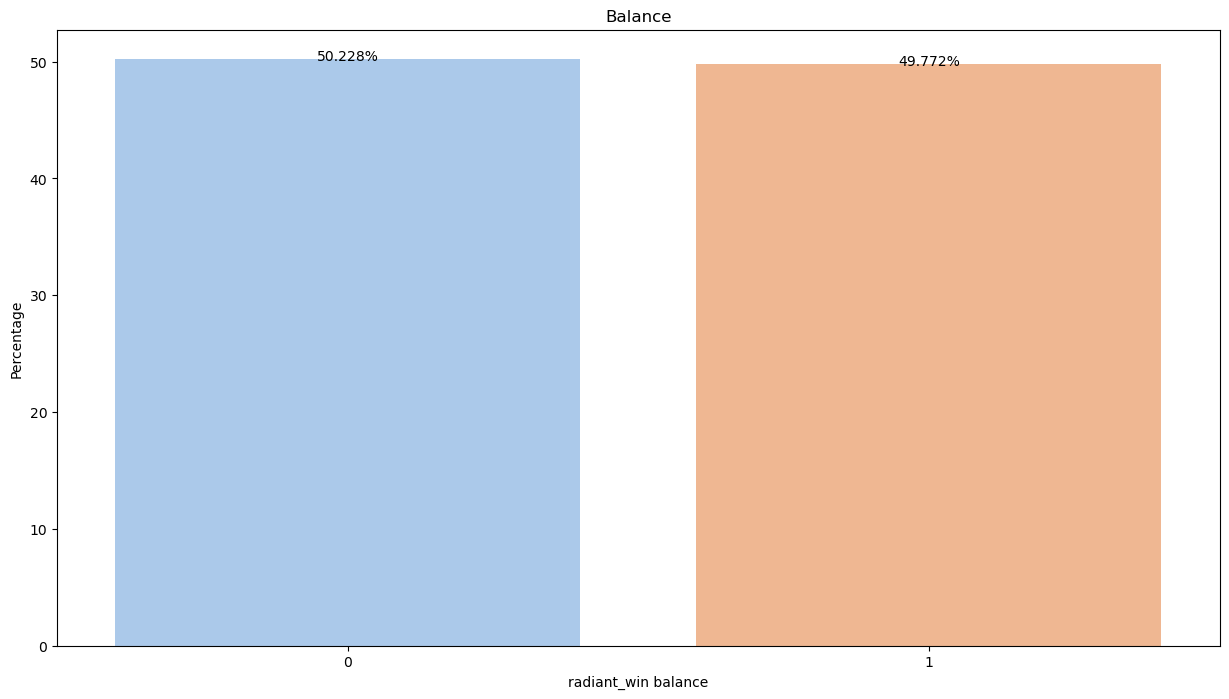

In [700]:
barplot_balance(df_dota, 'radiant_win')

Дизбаланс классов отсутствует

In [701]:
df_dota['radiant_win'] = df_dota['radiant_win'].astype(int)

Сохраним финальную версию датасета.

In [702]:
df_dota.to_csv('df_dota.csv', index=False)